# ARIMA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import matplotlib
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import math
import numpy as np
import statsmodels.api as sm
import itertools
import sys
from pyramid.arima import auto_arima

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


os.chdir('/Users/pierlim/PycharmProjects/IndianTV')
df = pd.read_csv("./data/ActualRatings_weeklyGRP.csv")
df = df.drop(df.columns[2], axis=1)
split_str = df['GRPRatingsDate'].str.split('(')
df['GRPRatingsDate'] = split_str.str[0]
df['GRPRatingsDate'] = pd.to_datetime(df['GRPRatingsDate'])

df = df.set_index('GRPRatingsDate')
df.plot(style='.-', figsize=(16, 9))
plt.title('Weekly Ratings 2007 - 2009')
plt.show()
df.tail()

<Figure size 1600x900 with 1 Axes>

,GRP
GRPRatingsDate,
2009-02-15,204.20
2009-02-22,200.61
2009-03-01,208.56
2009-03-08,191.74
2009-03-15,222.07


In [2]:
# log transform
#df = df['GRP'].apply(np.log)

# Get train test
df_train = df[:'2008-10-26']
print(df_train.tail())
print(df_train.shape)

df_test = df['2008-11-1':]
print(df_test.head())
print(df_test.shape)


                   GRP
GRPRatingsDate        
2008-09-28      219.91
2008-10-05      193.84
2008-10-12      201.30
2008-10-19      198.40
2008-10-26      170.74
(72, 1)
                   GRP
GRPRatingsDate        
2008-11-02      206.61
2008-11-09      188.68
2008-11-16      197.64
2008-11-23      193.16
2008-11-30      184.74
(20, 1)


In [3]:
print(df)


                   GRP
GRPRatingsDate        
2007-06-17      243.60
2007-06-24      263.19
2007-07-01      269.89
2007-07-08      252.88
2007-07-15      303.46
2007-07-22      286.29
2007-07-29      292.28
2007-08-05      288.72
2007-08-12      285.70
2007-08-19      286.01
2007-08-26      308.59
2007-09-02      320.57
2007-09-09      312.67
2007-09-16      278.58
2007-09-23      303.06
2007-09-30      327.22
2007-10-07      315.14
2007-10-14      254.39
2007-10-21      258.73
2007-10-28      272.35
2007-11-04      234.26
2007-11-11      259.35
2007-11-18      272.67
2007-11-25      269.03
2007-12-02      291.72
2007-12-09      275.29
2007-12-16      276.38
2007-12-23      274.68
2007-12-30      273.70
2008-01-06      271.84
...                ...
2008-08-24      205.17
2008-08-31      195.25
2008-09-07      212.45
2008-09-14      232.21
2008-09-21      236.31
2008-09-28      219.91
2008-10-05      193.84
2008-10-12      201.30
2008-10-19      198.40
2008-10-26      170.74
2008-11-02 

## Auto-arima

In [62]:
print(df_train.head())
stepwise_fit = auto_arima(df_train, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=False, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True, n_fits=100)  # set to stepwise

print(stepwise_fit.summary())


               GRP
2007-06-17  243.60
2007-06-24  263.19
2007-07-01  269.89
2007-07-08  252.88
2007-07-15  303.46
Fit ARIMA: order=(1, 1, 1); AIC=616.870, BIC=625.921, Fit time=0.068 seconds
Fit ARIMA: order=(0, 1, 0); AIC=621.776, BIC=626.302, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=620.114, BIC=626.902, Fit time=0.016 seconds
Fit ARIMA: order=(0, 1, 1); AIC=616.933, BIC=623.721, Fit time=0.019 seconds
Fit ARIMA: order=(2, 1, 1); AIC=617.426, BIC=628.740, Fit time=0.055 seconds
Fit ARIMA: order=(1, 1, 2); AIC=618.110, BIC=629.423, Fit time=0.101 seconds
Fit ARIMA: order=(2, 1, 2); AIC=619.018, BIC=632.594, Fit time=0.095 seconds
Total fit time: 0.358 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   71
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -304.435
Method:                       css-mle   S.D. of innovations             17.279
D

In [63]:

future_forecast = stepwise_fit.predict(n_periods=20)
df_forecast = pd.DataFrame(future_forecast, index=df_test.index)
df_forecast = df_forecast.rename(columns={ df_forecast.columns[0]: "forecast" })
#pd.concat([df, df_forecast], axis=1).plot()

In [64]:
df_forecast.tail()

,forecast
GRPRatingsDate,
2009-02-15,181.173193
2009-02-22,179.840303
2009-03-01,178.502823
2009-03-08,177.162323
2009-03-15,175.819837


In [65]:
# Test metrics
mae = mean_absolute_error(df_test['GRP'], df_forecast['forecast'])
mse = mean_squared_error(df_test['GRP'], df_forecast['forecast'])
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE),  ({:.2f} MAE)'.format(mse, math.sqrt(mse), mae))
mape = mean_absolute_percentage_error(df_test['GRP'], df_forecast['forecast'])
print('Prediction quality: {:.2f}% MAPE '.format(mape))

Prediction quality: 485.51 MSE (22.03 RMSE),  (17.55 MAE)
Prediction quality: 8.37% MAPE 


## Use the statesspace model to get a nicer graph, and confidence intervals

In [97]:
df_train.index = pd.DatetimeIndex(df_train.index.values,
                               freq=df_train.index.inferred_freq)


test_model = sm.tsa.statespace.SARIMAX(df_train, order=(1,1,1), enforce_stationarity=True)
results = test_model.fit()
pred = results.get_prediction(start=pd.to_datetime('2008-11-02'), end=pd.to_datetime('2009-03-15 '), dynamic=True)
pred_ci = pred.conf_int()

Observation : There is still some seasonality observed in the standardized residual. 

In [98]:
pred = results.get_prediction(start=pd.to_datetime('2008-11-02'), end=pd.to_datetime('2009-03-15 '), dynamic=True)
pred_ci = pred.conf_int()
print(pred.predicted_mean)

2008-11-02    181.379676
2008-11-09    183.927966
2008-11-16    184.538302
2008-11-23    184.684483
2008-11-30    184.719494
2008-12-07    184.727880
2008-12-14    184.729888
2008-12-21    184.730369
2008-12-28    184.730484
2009-01-04    184.730512
2009-01-11    184.730519
2009-01-18    184.730520
2009-01-25    184.730521
2009-02-01    184.730521
2009-02-08    184.730521
2009-02-15    184.730521
2009-02-22    184.730521
2009-03-01    184.730521
2009-03-08    184.730521
2009-03-15    184.730521
Freq: W-SUN, dtype: float64


In [99]:
mae = mean_absolute_error(df_test['GRP'], pred.predicted_mean)
mse = mean_squared_error(df_test['GRP'], pred.predicted_mean)
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE),  ({:.2f} MAE)'.format(mse, math.sqrt(mse), mae))
mape = mean_absolute_percentage_error(df_test['GRP'], pred.predicted_mean)
print('Prediction quality: {:.2f}% MAPE '.format(mape))

Prediction quality: 450.28 MSE (21.22 RMSE),  (17.13 MAE)
Prediction quality: 8.16% MAPE 


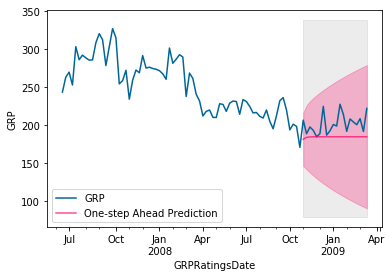

In [100]:
ax = df['2007-6-17':].plot(label='Observed', color='#006699')
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066');
# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2008-11-02'), df.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('GRPRatingsDate')
ax.set_ylabel('GRP')
plt.legend(loc='lower left')
plt.show()


In [108]:
test_mode

<bound method MLEModel.score of <statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x106d06b70>>

## Seasonal model with statespace to get graph

In [70]:
df_train.index = pd.DatetimeIndex(df_train.index.values,
                               freq=df_train.index.inferred_freq)

test_model = sm.tsa.statespace.SARIMAX(df_train, order=(0, 1, 3), seasonal_order=(0, 1, 1, 12))
results = test_model.fit()
pred = results.get_prediction(start=pd.to_datetime('2008-11-02'), end=pd.to_datetime('2009-03-15 '), dynamic=True)
pred_ci = pred.conf_int()

In [71]:
mae = mean_absolute_error(df_test['GRP'], pred.predicted_mean)
mse = mean_squared_error(df_test['GRP'], pred.predicted_mean)
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE),  ({:.2f} MAE)'.format(mse, math.sqrt(mse), mae))
mape = mean_absolute_percentage_error(df_test['GRP'], pred.predicted_mean)
print('Prediction quality: {:.2f}% MAPE '.format(mape))

Prediction quality: 2358.79 MSE (48.57 RMSE),  (45.14 MAE)
Prediction quality: 22.02% MAPE 


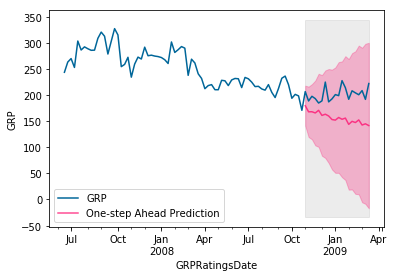

In [72]:
ax = df['2007-6-17':].plot(label='Observed', color='#006699')
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066');
# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2008-11-02'), df.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('GRPRatingsDate')
ax.set_ylabel('GRP')
plt.legend(loc='lower left')
plt.show()
